In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import os, sys, math
import subprocess
import re

def parse_profiling_info(prof_info, prof_type="mean"):
    if prof_type != 'mean' and prof_type != 'total':
        sys.stderr.write("option prof_type for parse_profiling_info() must be 'mean' or 'total'")
        return None
    prof_info_dict = {}
    keys = []
    prof_offset = prof_info.find(prof_type);
    prof_info = prof_info[prof_offset+6:-1]
    prof_info = prof_info.split('\\n')
    for i, line in enumerate(prof_info):
        val = re.search('[a-zA-z0-9]+', line);
        
        if (val == None) or ('.TAU' in line) or ('MPI_Datatype' in line) or ('_GLOBAL' in line) \
        or ('MPI_' in line and 'Allreduce()' not in line) or ('::' in line) \
        or ('initialization_and_destruction' in line) or ('main' in line) or ('Read_Statistic' in line):
            continue
        else:
            #print(line)
            line = line.split()
            for j, word in enumerate(line):
                if('sec' in word) or ('%Time' in word) or ('void' in word) or ('Read_Statistic' in word) \
                or (j > 7) or (j == 0) or ('total' in word and i == 3):
                    continue;
                else:
                    #print(j)
                    if i == 2:
                        if word not in keys:
                            keys.append(word)
                            prof_info_dict[keys[-1]] = []
                    else:
                        if j == 5 or j > 7:
                            continue;
                        elif j == 6 or j == 7:
                            func_name = word[0:word.find('<double>')]
                            prof_info_dict[keys[-1]].append(func_name)
                        else:
                            prof_info_dict[keys[j-1]].append(float(word))
    return prof_info_dict

def plot_time_breakdown(profiles_path, cmap='gnuplot', dset_name = '', save=False):
    if not os.path.isdir(profiles_path):
        sys.stderr.write("option profiles_path is not a directory\n")

    if not profiles_path.endswith('/'):
        profiles_path += '/'
    profiles = [f for f in os.listdir(profiles_path)]
    profiles.sort()
    casgd_files = profiles[1:]
    casgd_files.sort(key=lambda x : int(x[x.rfind('_s')+2:]))
    casgd_files.insert(0, profiles[0])
    profiles = casgd_files
    nfiles = len(profiles)
    #print(profiles)
    #plt.style.use('seaborn')
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    print(colors)
    
    cm = plt.get_cmap(cmap)
    colors = []
    for i in range(10):
        colors.append(cm(i/3*3.0/10))
    #print(colors)
    abs_path = os.getcwd() + '/';
    color_map = {}
    name_ordering = ['logistic_regression', 'axpy', 'MPI_Allreduce(', 'sparse_dot', 'sparse_scal', 'compute_gram_matrix', 'sparse_gemv']
    svals = ['SGD']
    for i, p_file in enumerate(profiles):
        if i > 0:
            svals.append('s = '+(p_file[p_file.rfind('s')+1:]))
        curr_path = abs_path + profiles_path + p_file;
        #print(abs_path + profiles_path + p_file)
        os.chdir(curr_path)
        cmd = ['pprof', '-p', '-s', '-t']
        popen = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
        popen.wait()
        prof = str(popen.stdout.read())
        #print(prof)
        profile_info = parse_profiling_info(prof)
        #print(profile_info)
        if (profile_info == None):
            os.chdir(abs_path)
            sys.exit(-1)
        times = [];
        running_sum = 0.
        
        #if(i == 0):
        #    name_ordering = profile_info['Name']
        #elif (i == 1):
        #    for (val) in (profile_info['Name']):
        #        if val not in name_ordering and ('logistic_regression' not in val):
        #            name_ordering.append(val)
        idx = 0
        #name_ordering.sort(key=len)
        #print(name_ordering)
        for val in (name_ordering):
            if val == 'logistic_regression' and val not in profile_info['Name']:
                idx = profile_info['Name'].index('ca_logistic_regression')
                times.append(profile_info['Exclusive'][idx])
                plt.bar(i, times[-1]/1000, color=color_map['Overhead'], bottom=running_sum)
            elif val == 'logistic_regression':
                idx = profile_info['Name'].index(val)
                times.append(profile_info['Exclusive'][idx])
                if 'Overhead' not in color_map.keys():
                    color_map['Overhead'] = colors[-1]
                    colors.pop()
                    plt.bar(i, times[-1]/1000, color=color_map['Overhead'], bottom=running_sum, label='Overhead')
                else:
                    plt.bar(i, times[-1]/1000, color=color_map['Overhead'], bottom=running_sum)
            else:
                try:
                    idx = profile_info['Name'].index(val)
                except ValueError:
                    continue;
                times.append(profile_info['Exclusive'][idx])
                if val not in color_map.keys():
                    color_map[val] = colors[-1]
                    colors.pop()
                    labelval = val
                    if 'MPI' in val:
                        labelval = val[:-1]
                    elif 'parallel_read' in val:
                        labelval = 'Parallel Read'
                    plt.bar(i, times[-1]/1000, color=color_map[val], label=labelval, bottom=running_sum)
                else:
                    plt.bar(i, times[-1]/1000, color=color_map[val], bottom=running_sum)
            running_sum += times[-1]/1000
        print(running_sum)
    ax = plt.gca()
    box = ax.get_position()
    ax.grid(color='k', axis='y', alpha=.2)
    ml = MultipleLocator(2.5)
    ax.yaxis.set_minor_locator(ml)
    #ax.yaxis.grid(True, which='minor')
    #ax.minorticks_on()

    plt.xticks(range(nfiles), svals, rotation=45)
    #ax.tick_params(axis='y', which='minor', bottom=False)
    #ax.set_position([box.x0, box.y0, box.width * 0.66, box.height])
    plt.ylabel('Running Time (sec.)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()

    os.chdir(abs_path)
    if save:
        plt.savefig(dset_name+'_rtbreakdown.pdf', dpi=300)
    plt.show()


In [ ]:
plt.cla()

profiles_path = 'sample_logs/news20_profiling_p24'
plot_time_breakdown(profiles_path,cmap='tab20c_r', dset_name='news20_p24', save=False)

l = ['logistic_regression', 'axpy', 'MPI_Allreduce(', 'sparse_dot', 'sparse_scal']


<IPython.core.display.Javascript object>


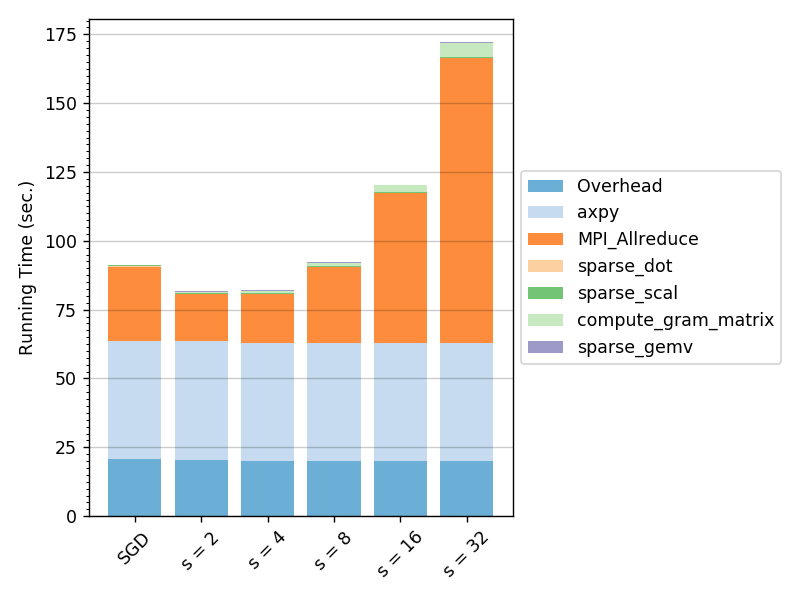

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
77.44300000000001
44.818
31.615000000000002
29.740199999999998
39.1068
61.33339999999999


In [2]:
plt.cla()
profiles_path = 'sample_logs/news20_profiling_p192'
plot_time_breakdown(profiles_path,cmap='tab20c_r', dset_name='news20_p192', save=False)

In [3]:
plt.cla()
profiles_path = 'sample_logs/news20_profiling_p48'
plot_time_breakdown(profiles_path,cmap='tab20c_r', dset_name='news20_p48', save=True)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
91.37899999999999
81.73899999999999
81.96699999999998
92.247
120.36280000000001
172.05810000000002


### Colormaps for automated color cycling
**Selecting the best color map is a manual process right now.**

**nipy_spectral** seems to work well.

Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r
